# Benjamin Tollison

In [1]:
import os
import subprocess
import matplotlib.pyplot as plt
import numpy as np
from GPyOpt.methods import BayesianOptimization

current_dir = os.getcwd()
print(current_dir)
# Make sure xfoil.exe exists in the current directory
assert os.path.exists(os.path.join(current_dir, 'xfoil.exe')), "xfoil.exe not found in the current directory"

c:\Users\benja\OneDrive\Documents\GitHub\School24\Aero 489\Hw4


In [2]:
def PrintAirfoil(cooridnates):
  x_coords = cooridnates[:,0]
  y_coords = cooridnates[:,1]
  
  # Print the extracted coordinates
  # print("X coordinates:", x_coords)
  # print("Y coordinates:", y_coords)

  plt.figure(figsize=(8, 6))
  plt.plot(x_coords, y_coords)
  plt.gca().set_aspect('equal', adjustable='box')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title('Modified NACA 0012')
  plt.grid(True)
  plt.show()
  return None

In [3]:
def GenerateAirfoil(filename:str,thickness:float,camber:float)->list:
  """
  Modify NACA airfoil coordinates in a .dat file based on new thickness and camber parameters.
    
  Parameters:
      filename (str): Path to the .dat file containing NACA airfoil coordinates.
      new_thickness (float): New maximum thickness as a fraction of chord length (0.01 to 0.99).
      new_camber (float): New maximum camber as a fraction of chord length (0.0 to 0.05).
    
  Returns:
      numpy.ndarray: Modified NACA airfoil coordinates (x, y).
  """
  # Read existing airfoil coordinates from the .dat file
  airfoil_coords = np.loadtxt(f"{filename}.dat")
    
  # Scale coordinates based on new thickness and camber parameters
  x = airfoil_coords[:, 0]
  y = airfoil_coords[:, 1]
  x_scaled = x
  y_scaled = y * (thickness / 0.12)  # Scale thickness
  y_scaled += (camber / 0.02) * 0.12 * (0.2969 * np.sqrt(x) - 0.1260 * x - 0.3516 * x ** 2 + 0.2843 * x ** 3 - 0.1015 * x ** 4)  # Scale camber
    
  # Combine scaled coordinates into a new array
  modified_airfoil_coords = np.column_stack([x_scaled, y_scaled])
  # Save modified airfoil coordinates to a new .dat file
  modified_filename = f"modified_{filename}.dat"
  np.savetxt(modified_filename, modified_airfoil_coords, fmt=['    %1.6f','%1.6f'], delimiter='    ')#, header=f"Modified Airfoil: {filename}", comments='')
  return modified_airfoil_coords

In [4]:
def LiftDragRatio(polar_input_dict):
  alpha = polar_input_dict['alpha']
  cl = polar_input_dict['CL']
  cd = polar_input_dict['CD']
  lift_over_drag_discrete = []
  for index in range(len(cl)):
    lift_over_drag_discrete.append(cl[index]/cd[index])
  polyfit_coeffiecients = np.polyfit(alpha,lift_over_drag_discrete,5)
  return np.poly1d(polyfit_coeffiecients)

In [5]:
### Reset modified Naca files
try:
  GenerateAirfoil('NACA0012',0.12,0).T
  print('Successfully Reset Modified NACA0012.dat')
except:
  print('Failed to reset Modified NACA0012.dat')

Successfully Reset Modified NACA0012.dat


In [6]:
def ObjectiveFunction(input_vector):
  # thickness, camber = input_vector[0], input_vector[1]
  thickness, camber = input_vector[:,0], input_vector[:,1]
  design_angle_of_attack = input_vector[:,2] #degrees
  # params for XFOIL
  base_airfoil_file = 'NACA0012'
  airfoil_name = 'modified_NACA0012'
  #airfoil_name = 'NACA0012'
  alpha_i = 0
  alpha_f = 10
  alpha_step = 0.25
  Re = 2.74e7
  Mach = 1.6
  Type = int(1)
  n_iter = 250

  new_coords = GenerateAirfoil(base_airfoil_file,thickness,camber)
  PrintAirfoil(new_coords)

  if os.path.exists("polar_file.txt"):
    os.remove("polar_file.txt")
  input_file = open("input_file.in", 'w')
  input_file.write("LOAD {0}.dat\n".format(airfoil_name))
  input_file.write(airfoil_name + '\n')
  input_file.write("PANE\n")
  input_file.write("OPER\n")
  input_file.write("Visc {0}\n".format(Re))
  # input_file.write("Mach {0}\n".format(Mach))
  input_file.write("Type {0}\n".format(Type))
  input_file.write("PACC\n")
  input_file.write("polar_file.txt\n\n")
  input_file.write("ITER {0}\n".format(n_iter))
  input_file.write("ASeq {0} {1} {2}\n".format(alpha_i, alpha_f,alpha_step))
  input_file.write("\n\n")
  input_file.write("quit\n")
  input_file.close()
  try:
    output = subprocess.check_output("xfoil.exe < input_file.in", shell=True, stderr=subprocess.STDOUT)
    # print("XFOIL output:", output)
  except subprocess.CalledProcessError as e:
    print("Error executing XFOIL command:", e.output)

  polar_data = np.loadtxt("polar_file.txt", skiprows=12)
  data = {}
  data["alpha"] = polar_data[:, 0]
  data["CL"] = polar_data[:, 1]
  data["CD"] = polar_data[:, 2]
  data["CDp"] = polar_data[:, 3]
  data["CM"] = polar_data[:, 4]
  data["Top_Xtr"] = polar_data[:, 5]
  data["Bot_Xtr"] = polar_data[:, 6]

  lift_over_drag_function = LiftDragRatio(data)
  lift_over_drag = lift_over_drag_function(design_angle_of_attack)
  return lift_over_drag


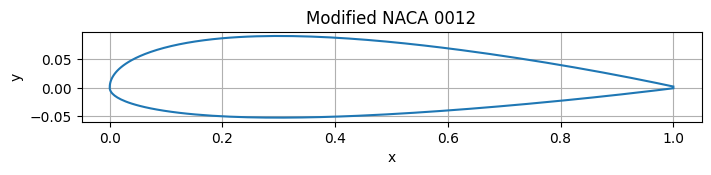

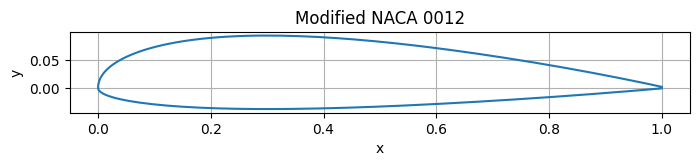

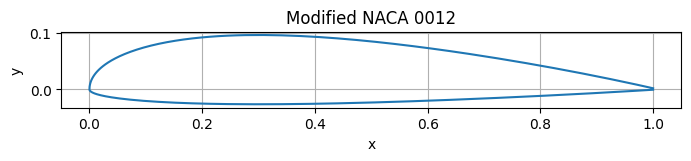

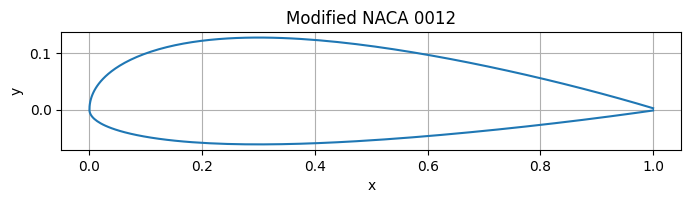

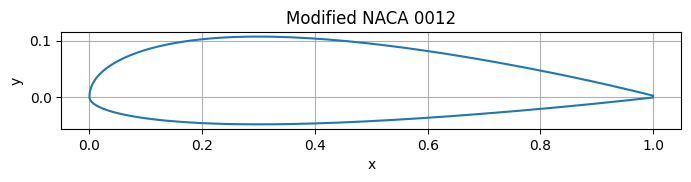

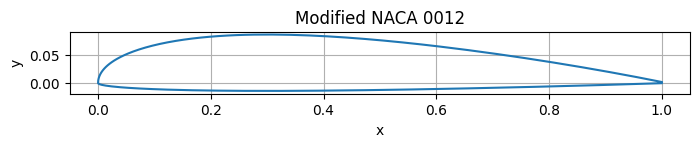

num acquisition: 1, time elapsed: 7.68s


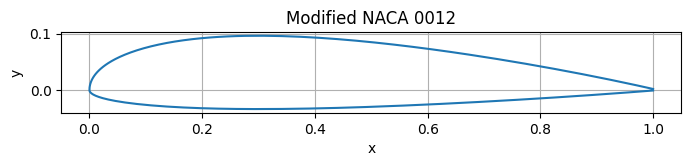

num acquisition: 2, time elapsed: 13.21s


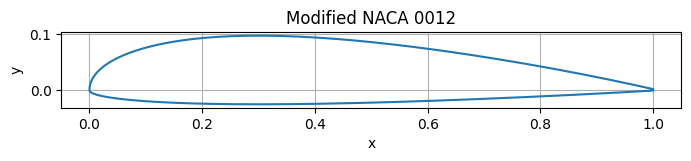

num acquisition: 3, time elapsed: 23.11s


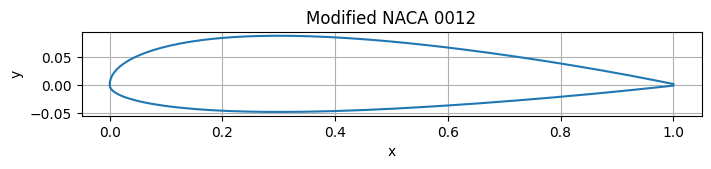

num acquisition: 4, time elapsed: 26.18s


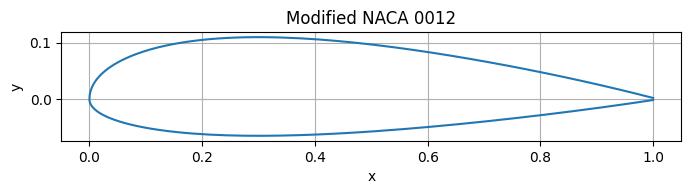

num acquisition: 5, time elapsed: 28.39s


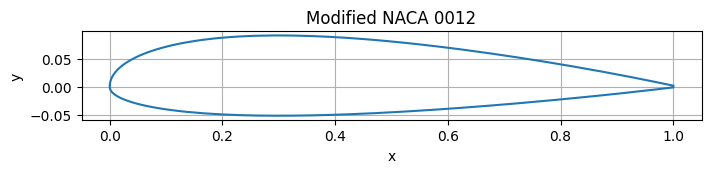

num acquisition: 6, time elapsed: 32.94s


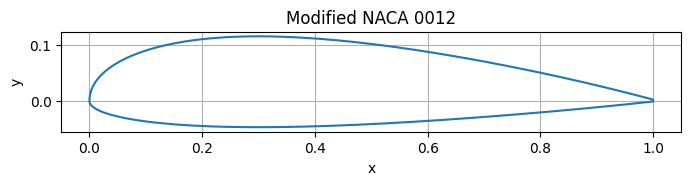

num acquisition: 7, time elapsed: 37.65s


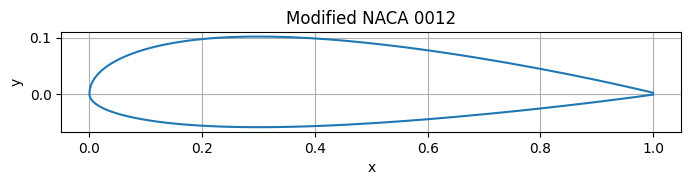

num acquisition: 8, time elapsed: 39.86s


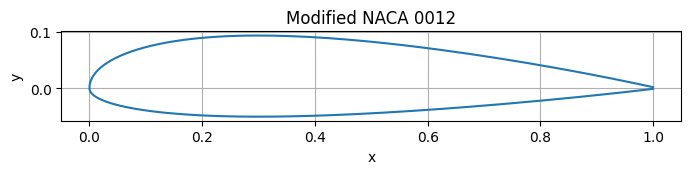

num acquisition: 9, time elapsed: 41.11s


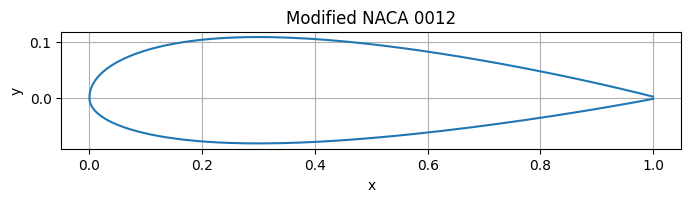

num acquisition: 10, time elapsed: 43.11s


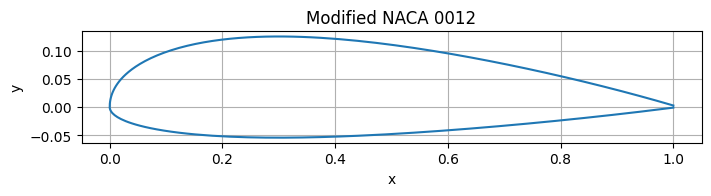

num acquisition: 11, time elapsed: 46.94s


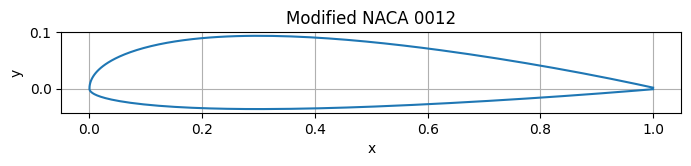

num acquisition: 12, time elapsed: 53.45s


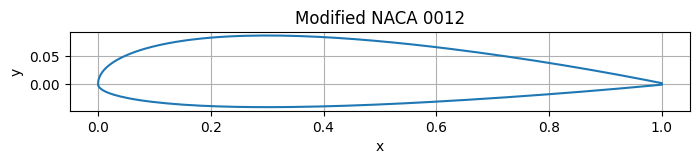

num acquisition: 13, time elapsed: 56.61s


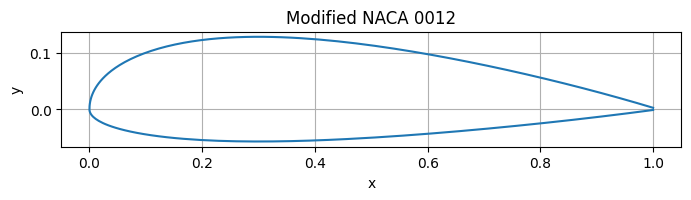

num acquisition: 14, time elapsed: 58.00s


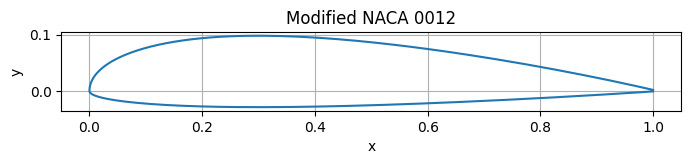

num acquisition: 15, time elapsed: 63.60s


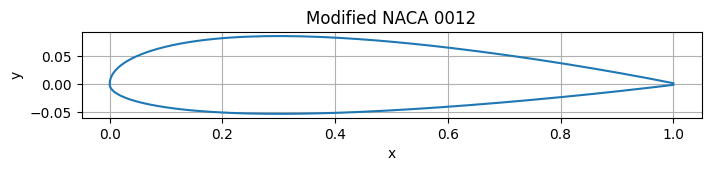

num acquisition: 16, time elapsed: 65.82s


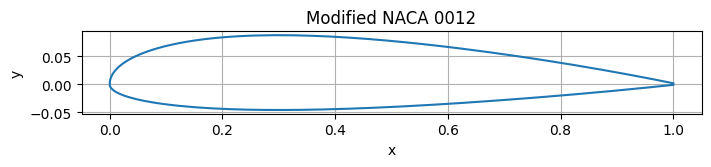

num acquisition: 17, time elapsed: 69.52s


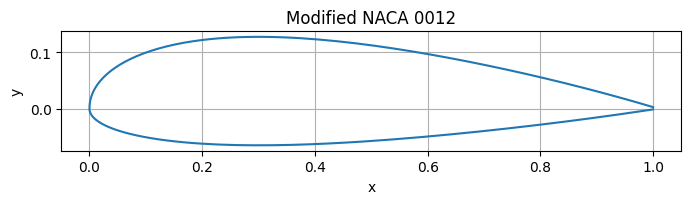

num acquisition: 18, time elapsed: 71.81s


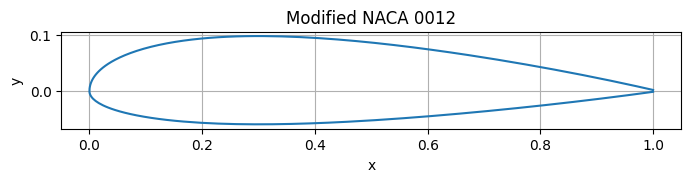

num acquisition: 19, time elapsed: 73.99s


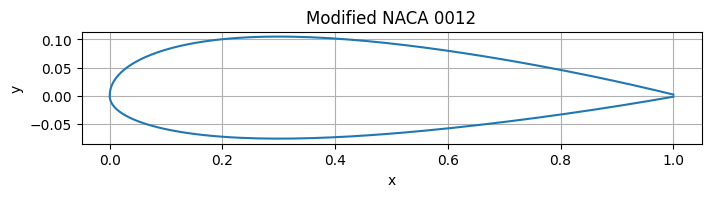

num acquisition: 20, time elapsed: 76.05s


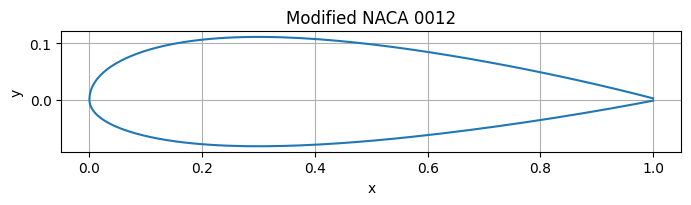

num acquisition: 21, time elapsed: 80.80s


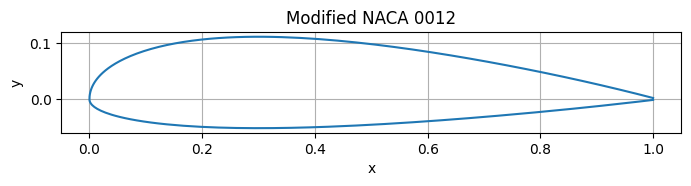

num acquisition: 22, time elapsed: 84.61s


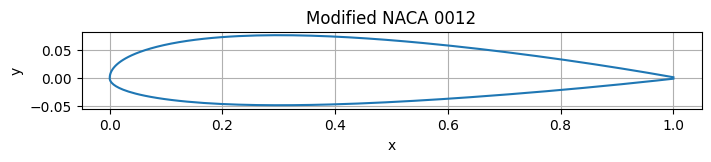

num acquisition: 23, time elapsed: 87.52s


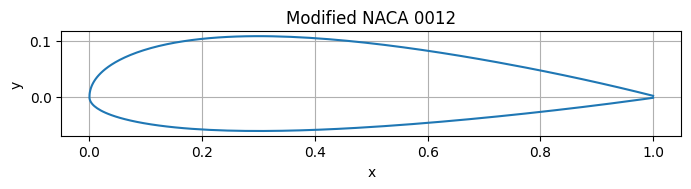

num acquisition: 24, time elapsed: 89.59s


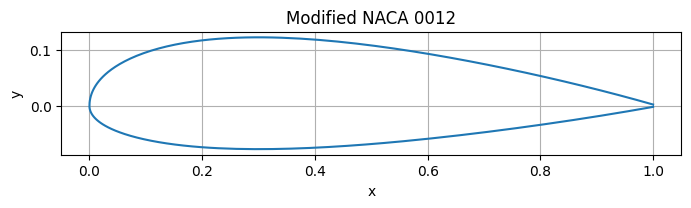

num acquisition: 25, time elapsed: 92.37s


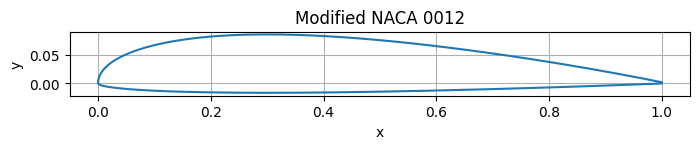

num acquisition: 26, time elapsed: 101.06s


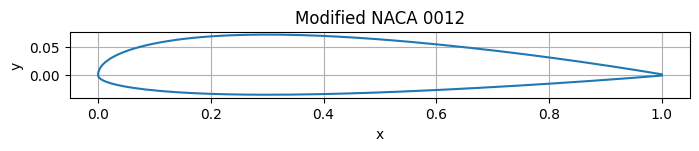

num acquisition: 27, time elapsed: 106.42s


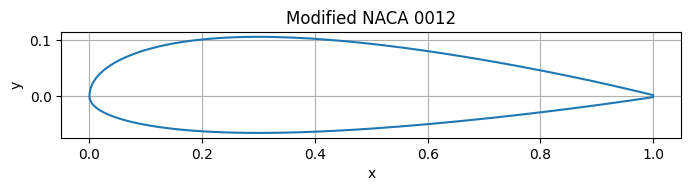

num acquisition: 28, time elapsed: 107.70s


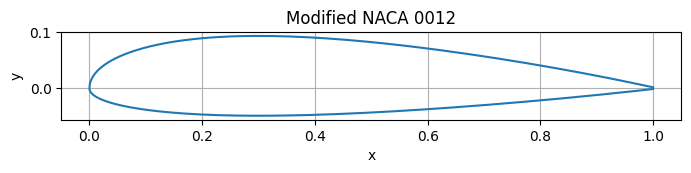

num acquisition: 29, time elapsed: 109.06s


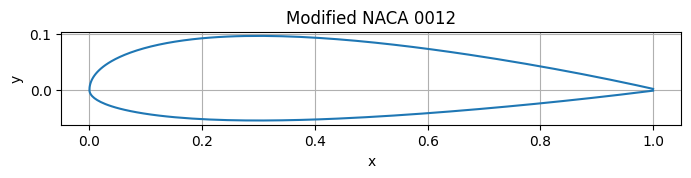

num acquisition: 30, time elapsed: 111.16s


In [7]:
bounds = [
  {'name':'thickness','type':'continuous','domain':(0.1,0.2)},
  {'name':'camber','type':'continuous','domain':(0.02,0.06)},
  {'name':'aoa','type':'continuous','domain':(0.0,10.0)}
]

optimizer = BayesianOptimization(
  f=ObjectiveFunction,
  domain=bounds,
  model_type='GP',
  acquisition_type='EI',
  exact_feval=True,
  maximize=False
)
intial_number_data = 0
max_iterations = 30
optimizer.run_optimization(max_iter=max_iterations,verbosity=True)

Optimal Design: 
 Thickness=0.12284897550276772 
 Camber=0.05849578133478697
 AoA=9.314348829447507 [deg]


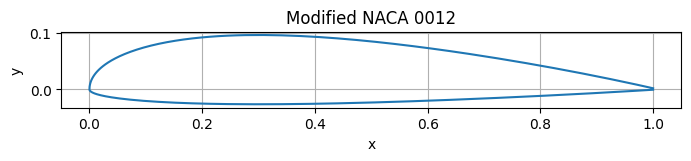

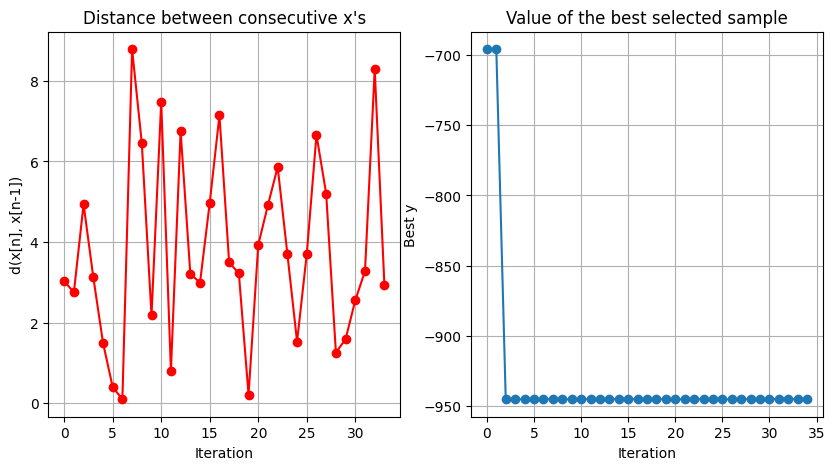

In [8]:
print("Optimal Design: \n Thickness={0} \n Camber={1}\n AoA={2} [deg]".format(optimizer.x_opt[0],optimizer.x_opt[1],optimizer.x_opt[2]))
PrintAirfoil(GenerateAirfoil('NACA0012',optimizer.x_opt[0],optimizer.x_opt[1]))
optimizer.plot_convergence()